# Проект: Статистический анализ данных

В ходе проекта необходимо проанализировать сервис аренды самокатов GoFast.  
Для анализа были получены 3 базы данных - о пользователях, их поездках и подписках.  
Заказчиком поставлена следующие задачи:  
1) Проанализировать города использования самокатов;  
2) Соотношение подписчиком к тем кто без подписки;  
3) Возраст;  
4) Дистанцию поездок;  
5) Время поездок;  
6) Оценить выручка обоих категорий пользователей;  

Также заказчику инетересно проверить несколько гипотез:  
1) Тратят ли пользователи с подпиской больше времени на поездки?  
2) Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?  
3) Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.  
4) Снизилось ли число ображений в ТП, после оптимизации сервиса.  

Дополнительные задачи:  
1) Решить, сколько необходимо разослать промокодов, чтобы получить 100 новых подписчиков;  
2) Оценить вероятность, с какой будет открыто 399,5 тыс пушей после отправки 1млн.  

Приступим и для начала, изучим и обработаем предоставленные нам данные.

In [1]:
!pip install plotly

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats as st
from scipy.stats import binom, norm

# красивые выводы
sns.set()
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# сделаем функцию оценки пропусков в датасетах
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)

In [4]:
# сделаем функцию оценки предоставленного датасета
def check_data(data):
    # общая информация 
    display(data.info())

    # первые 5 строк
    display(data.head())
    
    # последние
    display(data.tail())
    
    # пропуски
    display(missing_data(data))
    
    # средние
    display(data.describe().T)
    
    # дубликаты будут отдельным блоком по задаче, не будем сюда включать

## Шаг 1. Загрузка данных

### Пользователи — users_go.csv

In [5]:
# загрузим файлы
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv', delimiter=',')
check_data(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

user_id        name  age            city subscription_type
0        1        Кира   22          Тюмень             ultra
1        2   Станислав   31            Омск             ultra
2        3     Алексей   20          Москва             ultra
3        4  Константин   26  Ростов-на-Дону             ultra
4        5       Адель   28            Омск             ultra

user_id     name  age            city subscription_type
1560      829    Федор   29       Пятигорск              free
1561      809     Юрий   26            Сочи              free
1562      307   Ясмина   19       Краснодар             ultra
1563       47     Юрий   28          Тюмень             ultra
1564     1045  Артемий   28  Ростов-на-Дону              free

Series([], dtype: int64)

None

count   mean    std   min    25%    50%     75%     max
user_id 1565.00 762.63 443.26  1.00 378.00 762.00 1146.00 1534.00
age     1565.00  24.92   4.55 12.00  22.00  25.00   28.00   43.00

### Поездки — rides_go.csv

In [6]:
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv', delimiter=',')
check_data(rides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

user_id  distance  duration        date
0        1   4409.92     25.60  2021-01-01
1        1   2617.59     15.82  2021-01-18
2        1    754.16      6.23  2021-04-20
3        1   2694.78     18.51  2021-08-11
4        1   4028.69     26.27  2021-08-28

user_id  distance  duration        date
18063     1534   3781.10     19.82  2021-11-04
18064     1534   2840.42     21.41  2021-11-16
18065     1534   3826.19     18.44  2021-11-18
18066     1534   2902.31     16.67  2021-11-27
18067     1534   2371.71     15.89  2021-12-29

Series([], dtype: int64)

None

count    mean     std  min     25%     50%     75%     max
user_id  18068.00  842.87  434.73 1.00  487.00  889.00 1213.25 1534.00
distance 18068.00 3070.66 1116.83 0.86 2543.23 3133.61 3776.22 7211.01
duration 18068.00   17.81    6.09 0.50   13.60   17.68   21.72   40.82

In [7]:
# сразу обработаем столбец даты и приведем к нормальному виду
rides['date'] = pd.to_datetime(rides['date']).dt.normalize()
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Подписки — subscriptions_go.csv

In [8]:
subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv', delimiter=',')
check_data(subs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199

subscription_type  minute_price  start_ride_price  subscription_fee
0              free             8                50                 0
1             ultra             6                 0               199

Series([], dtype: int64)

None

count  mean    std  min   25%   50%    75%    max
minute_price       2.00  7.00   1.41 6.00  6.50  7.00   7.50   8.00
start_ride_price   2.00 25.00  35.36 0.00 12.50 25.00  37.50  50.00
subscription_fee   2.00 99.50 140.71 0.00 49.75 99.50 149.25 199.00

### Выводы

Подключили и изучили данные из предоставленных данных:  
1) Исправили ошибку представления даты в файле rides  
2) Оценили пропуски - их нет  
3) Оценили общий вид данных - все в норме, корректировки не нужны  

## Шаг 2. Предобработка данных

### Приведите столбец date к типу даты pandas.

In [9]:
# сделано выше - п.1.2

### Создайте новый столбец с номером месяца на основе столбца date.

In [10]:
rides['date_month'] = rides['date'].dt.month
display(rides.head(2))
display(rides.tail(2))

user_id  distance  duration       date  date_month
0        1   4409.92     25.60 2021-01-01           1
1        1   2617.59     15.82 2021-01-18           1

user_id  distance  duration       date  date_month
18066     1534   2902.31     16.67 2021-11-27          11
18067     1534   2371.71     15.89 2021-12-29          12

In [11]:
# посмотрим разбег даты
display(rides['date'].min())
display(rides['date'].max())

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

Нам дали данные за 2021 год... шел 2025й, поэтому, вероятнее всего, аналитика на этих данных может уже и не соответствовать действительности, но опять же, заказчик - босс :)

### Проверьте наличие пропущенных значений и дубликатов в датафреймах

In [12]:
# пропущенные данные оценили выше - их нет
# проверим явные дубликаты в users
users.duplicated().sum()

31

In [13]:
#удаляем
users.drop_duplicates(keep='first').reset_index(drop=True)

user_id        name  age            city subscription_type
0           1        Кира   22          Тюмень             ultra
1           2   Станислав   31            Омск             ultra
2           3     Алексей   20          Москва             ultra
3           4  Константин   26  Ростов-на-Дону             ultra
4           5       Адель   28            Омск             ultra
...       ...         ...  ...             ...               ...
1529     1530   Ростислав   29            Сочи              free
1530     1531      Никита   25       Пятигорск              free
1531     1532     Алексей   26          Тюмень              free
1532     1533      Степан   22       Краснодар              free
1533     1534     Альберт   25       Краснодар              free

[1534 rows x 5 columns]

т.к. в базе присутствуют только имена пользователей - искать неявные дупликаты нет никакого смысла

In [14]:
# проверим явные дубликаты в rides
rides.duplicated().sum()

0

дубликатов нет  
неявные - аналогично как и с базой users

в базе subs 2 строки имеющие характеристики подписки и без

### Выводы

Првели к нормальному виду данные, создали новый столбец с месяцами, проверили и обработали дубликаты

## Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках

### Частота встречаемости городов

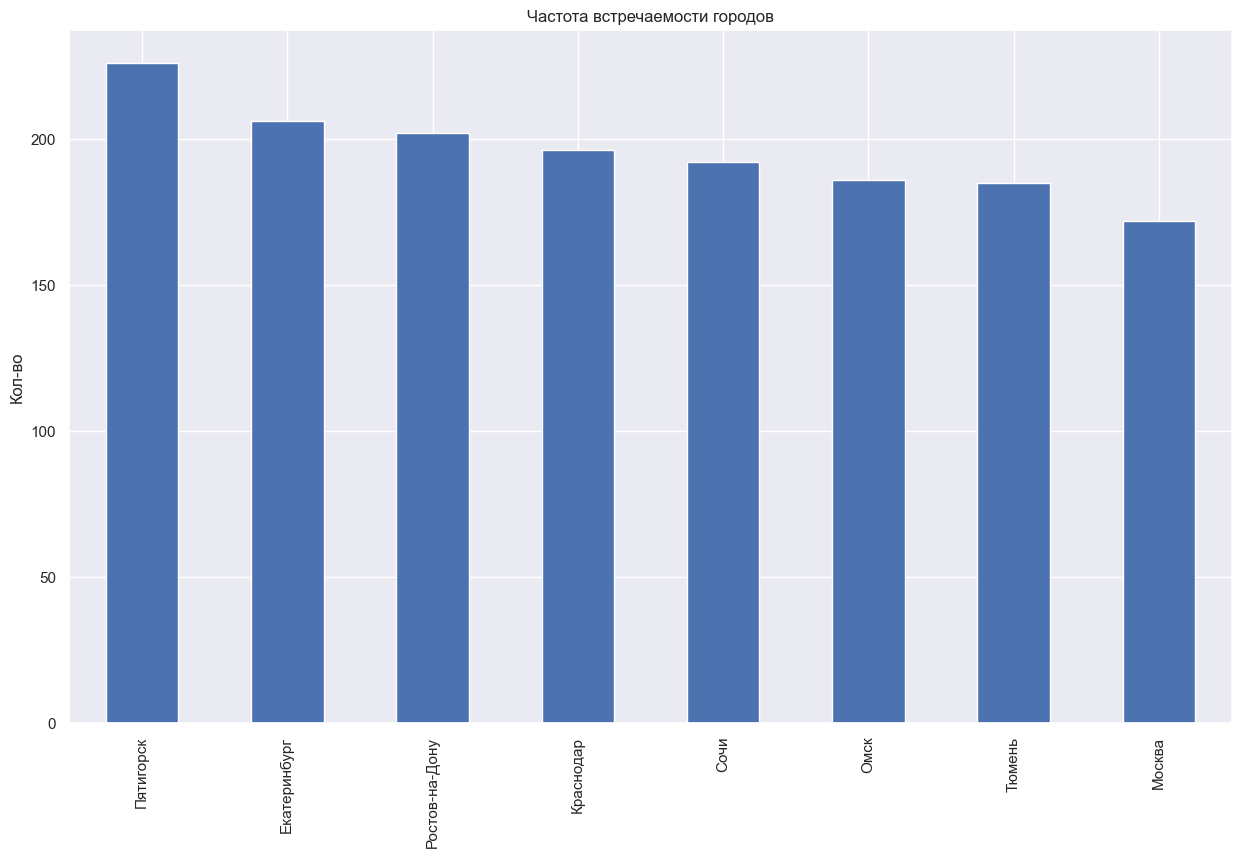

In [15]:
city_count = users['city'].value_counts()
plt.figure(figsize=(15, 9))
city_count.plot(kind='bar')
plt.title('Частота встречаемости городов')
plt.ylabel('Кол-во')
plt.show()

На удивление странная статистика, что в МСК меньше всего пользователей... Но работаем с тем, что есть.  
Пятигорск - лидер по пользователям  
На втором месте - Екатеринбург

Предположим, что сервис появился именно в Пятигорске и оттуда уже начал свое распространение.

### Соотношение пользователей с подпиской и без подписки

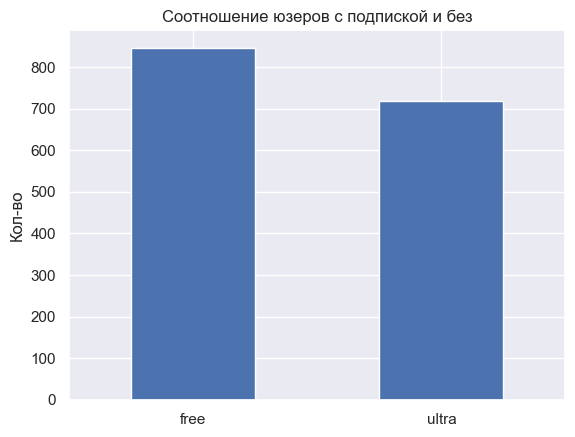

In [16]:
sub_count = users['subscription_type'].value_counts()
sub_count.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Соотношение юзеров с подпиской и без')
plt.ylabel('Кол-во')
plt.show()

In [17]:
# соотношение между двумя значениями
ratio = sub_count['ultra'] / sub_count['free']

# отношение каждого значения к максимальному значению
ratio_to_max = sub_count / users['subscription_type'].count()

print(f"Соотношение free к ultra: {round(ratio, 2)}")
print(f"Отношение каждого значения к максимальному:\n{ratio_to_max}")

Соотношение free к ultra: 0.85
Отношение каждого значения к максимальному:
free    0.54
ultra   0.46
Name: subscription_type, dtype: float64


Разница в пользу тех, кто без подписки, их больше половины всех пользователей  
Предположим, что они ездят не так часто, пару раз в год, поэтому она им и не нужна  
Тех, кто с подпиской, на 8% меньше

### Возраст пользователей

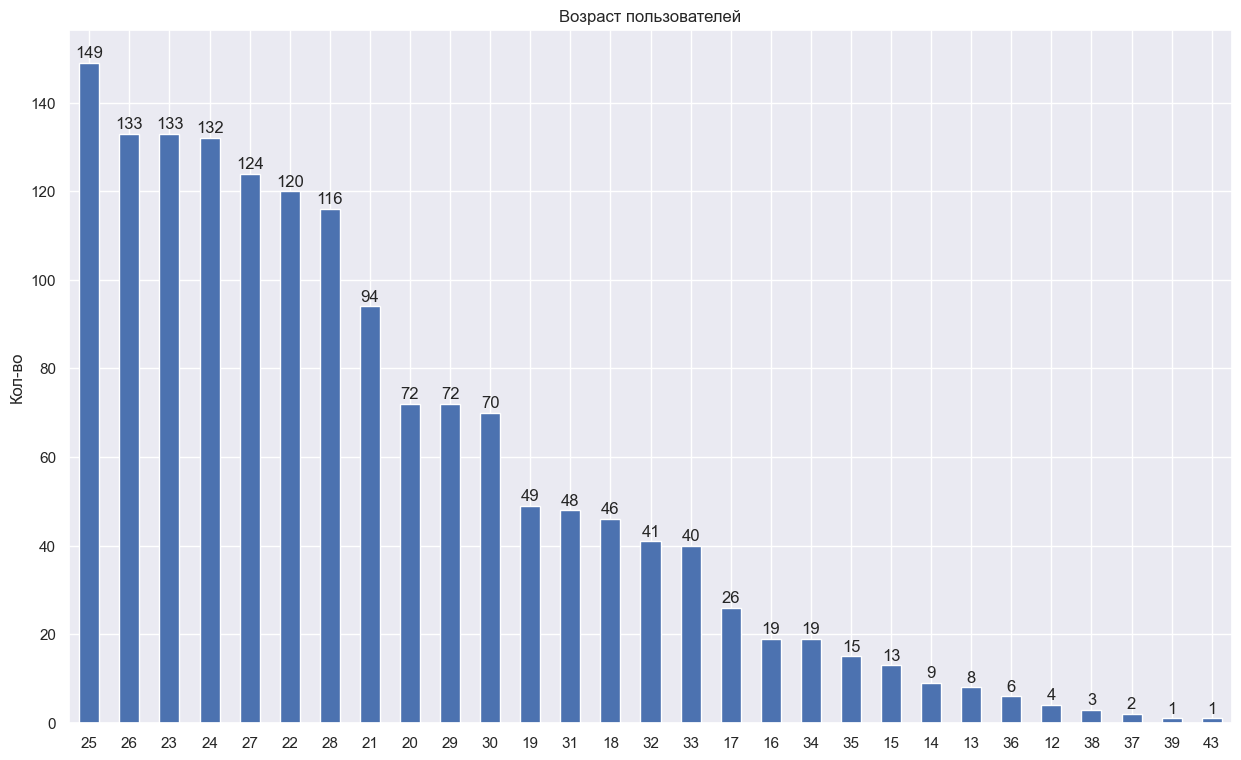

In [18]:
age_count = users['age'].value_counts()
plt.figure(figsize=(15, 9))
age_count.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Возраст пользователей')
plt.ylabel('Кол-во')

# добавляем количество значений над каждым столбцом
for i, value in enumerate(age_count):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
plt.show()

In [19]:
# хотим посмотреть, к какой возрастной категории будет соответствовать большинство пользователей
percent = 50 # какое большинство хотим посчитать
cumulative_count = age_count.cumsum()
total_users = cumulative_count.iloc[-1]
age_percent = cumulative_count[cumulative_count <= total_users * (percent / 100)]

# получаем минимальное и максимальное значение возраста в этой категории
min_age = age_percent.index.min()
max_age = age_percent.index.max()

# вычисляем процент пользователей младше 18 лет
under_18_count = users[users['age'] < 18].shape[0]
under_18_percent = (under_18_count / total_users) * 100

print(f'{percent}% пользователей попали в возрастную категорию: {min_age} - {max_age}.')
print(f'Детей (младше 18 лет) составляет {under_18_percent:.2f}% ({under_18_count} юзеров) от общего числа пользователей.')

50% пользователей попали в возрастную категорию: 23 - 27.
Детей (младше 18 лет) составляет 5.05% (79 юзеров) от общего числа пользователей.


1) Половина пользователей - это молодежь от 23 до 27  
2) Встречаются дети, что запрещено, т.е. они используют самокаты незаконно, надо доработать систему регистрации юзеров  
3) С повышением возраста - число юзеров падает  

### Расстояние, которое пользователь преодолел за одну поездку

In [20]:
# посмотрим на распределения каждой поездки
fig = px.histogram(rides, x='distance', nbins=50, 
                   labels={'distance': 'Расстояние'})

# наведение красоты
fig.update_layout(
    title='Гистограмма распределения расстояний',
    title_x=0.5,
    yaxis_title='Число'
)
fig.show()

In [21]:
value_checked = 'distance'
min_value = rides[value_checked].min()
max_value = rides[value_checked].max()
median_value = rides[value_checked].median()
percentile_5 = rides[value_checked].quantile(0.05)
percentile_95 = rides[value_checked].quantile(0.95)

# подсчет количества поездок в пределах 5% и 95%
count_5_percent_min = rides[(rides[value_checked] <= percentile_5)].shape[0]
count_5_percent_max = rides[(rides[value_checked] >= percentile_95)].shape[0]

print(f"Вывод по {value_checked}:")
print(f"Диапазон 5% минимальных значений: 0 - {percentile_5}, число повторений: {count_5_percent_min}")
print(f"Диапазон 5% максимальных значений: {percentile_95} - {max_value}")
print(f"Медианное значение: {median_value}")

Вывод по distance:
Диапазон 5% минимальных значений: 0 - 689.0072786504327, число повторений: 904
Диапазон 5% максимальных значений: 4740.088596032061 - 7211.007744598519
Медианное значение: 3133.6099936787664


На графике мы видим небольшой пик на поездках до 1000 метров, здесь несколько вариантов:  
1) Первый опыт, с целью посмотреть как, что и куда...;  
2) Послеобеденная поездка до офиса (я в этой группе)));  
3) Ошибки в выгруженных данных;  
4) Самокат сломался.

### Продолжительность поездок

In [22]:
# посмотрим на распределения каждой поездки
fig = px.histogram(rides, x='duration', nbins=50, 
                   labels={'duration': 'Время'})

# наведем красоты
fig.update_layout(
    title='Гистограмма распределения времени в пути',
    title_x=0.5,
    yaxis_title='Число'
)
fig.show()

In [23]:
value_checked = 'duration'
min_value = rides[value_checked].min()
max_value = rides[value_checked].max()
median_value = rides[value_checked].median()
percentile_5 = rides[value_checked].quantile(0.05)
percentile_95 = rides[value_checked].quantile(0.95)

# подсчет количества поездок в пределах 5% и 95%
count_5_percent_min = rides[(rides[value_checked] <= percentile_5)].shape[0]
count_5_percent_max = rides[(rides[value_checked] >= percentile_95)].shape[0]

print(f"Вывод по {value_checked}:")
print(f"Диапазон 5% минимальных значений: 0 - {percentile_5}, число повторений: {count_5_percent_min}")
print(f"Диапазон 5% максимальных значений: {percentile_95} - {max_value}")
print(f"Медианное значение: {median_value}")

Вывод по duration:
Диапазон 5% минимальных значений: 0 - 8.244527805151872, число повторений: 904
Диапазон 5% максимальных значений: 28.428729693752114 - 40.82396261922424
Медианное значение: 17.678394530393803


По продолжительности поездки мы видим почти 100 стартов до 1 минуты, здесь я также вижу несколько вариантов, почему так произошло:  
1) Тест приложения новым пользователем;  
2) Ошибочный старт (маловероятно, но все может быть);  
3) Резкая смена планов юзера...;   
4) Ошибки в выгруженных данных;  
5) Самокат сломался.

Здесь мы провели оценки встречаемости городов, соотношение юзеров с подпиской и без, возраст, расстояния и время, сколько в среднем накатывает каждый из юзеров

### Выводы

1) Ниболее часто встречаемый город - Пятигорск  
2) Пользователей с подпиской меньше на 8%  
3) Средний возраст 23 - 27  
4) Детей (младше 18 лет) составляет 5.05% (79 юзеров)  
5) В среднем все пользователи накатывают 3131,07 метров  
6) В среднем все пользователи накатывают 17 минут  

## Шаг 4. Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм

In [24]:
# для этого воспользуйтесь методом merge()
data = users.merge(
    rides, 
    left_on='user_id', 
    right_on='user_id', 
    how='outer'
)
display(data.head(2))
display(data.info())

user_id  name  age    city subscription_type  distance  duration  \
0        1  Кира   22  Тюмень             ultra   4409.92     25.60   
1        1  Кира   22  Тюмень             ultra   2617.59     15.82   

        date  date_month  
0 2021-01-01           1  
1 2021-01-18           1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18388 entries, 0 to 18387
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18388 non-null  int64         
 1   name               18388 non-null  object        
 2   age                18388 non-null  int64         
 3   city               18388 non-null  object        
 4   subscription_type  18388 non-null  object        
 5   distance           18388 non-null  float64       
 6   duration           18388 non-null  float64       
 7   date               18388 non-null  datetime64[ns]
 8   date_month         18388 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


None

In [25]:
# строк получилось больше чем надо, проверим дубликаты и удалим их
display(data.duplicated().sum())
data = data.drop_duplicates(keep='first').reset_index(drop=True)

320

In [26]:
display(data.duplicated().sum())

0

### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1

In [27]:
# c данными о пользователях без подписки;
data_sub_yes = data[data['subscription_type'] == 'ultra']
display(data_sub_yes.describe().T)

count    mean    std    min     25%     50%     75%     max
user_id    6500.00  348.73 201.10   1.00  175.00  351.00  525.00  699.00
age        6500.00   24.89   4.76  12.00   22.00   25.00   28.00   38.00
distance   6500.00 3115.45 836.90 244.21 2785.44 3148.64 3560.57 5699.77
duration   6500.00   18.54   5.57   3.76   14.52   18.18   21.88   40.82
date_month 6500.00    6.42   3.41   1.00    4.00    6.00    9.00   12.00

In [28]:
# с данными о пользователях с подпиской.
data_sub_no = data[data['subscription_type'] == 'free']
display(data_sub_no.describe().T)

count    mean     std    min     25%     50%     75%     max
user_id    11568.00 1120.53  241.17 700.00  915.00 1123.00 1328.00 1534.00
age        11568.00   24.89    4.48  12.00   22.00   25.00   28.00   43.00
distance   11568.00 3045.50 1246.17   0.86 2366.56 3114.65 3905.70 7211.01
duration   11568.00   17.39    6.33   0.50   12.96   17.33   21.59   34.95
date_month 11568.00    6.52    3.45   1.00    4.00    7.00    9.00   12.00

### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [29]:
# данные с подпиской
fig = px.density_heatmap(data_sub_yes, x='distance', y='duration', nbinsx=50, nbinsy=50, color_continuous_scale='Greens')
fig.update_layout(title='Зависимость расстояния от времени (подписка есть)',
    xaxis_title='Расстояние',
    yaxis_title='Время',
    width=600,
    height=500)
fig.show()

Из графика мы видим, что наиболее частые показатели это 3000-3200 м за 18-19 минут  
С такими показателями закончили наибольшее число поездок в количестве 91  

In [30]:
# данные без подписки
fig = px.density_heatmap(data_sub_no, x='distance', y='duration', nbinsx=50, nbinsy=50, color_continuous_scale='Greens')
fig.update_layout(title='Зависимость расстояния от времени (подписки нет)',
    xaxis_title='Расстояние',
    yaxis_title='Время',
    width=600,
    height=500)
fig.show()

В случае без подписки ситуация следующая  

Из графиков мы видим, что наиболее частые показатели это 2500-2700 м за 16-17 минут  
С такими показателями закончили наибольшее число поездок в количестве 80  

In [31]:
# наложим графики расстояния друг на друга для наглядности и оценки
fig = px.histogram(data_sub_yes, x='distance', nbins=50, 
                   labels={'distance': 'Расстояние'}, 
                   opacity=0.6, 
                   color_discrete_sequence=['green'], 
                   title='Гистограмма распределения пройденного расстояния')

# добавляем гистограмму для данных без подписки
fig.add_trace(px.histogram(data_sub_no, x='distance', nbins=50, 
                            labels={'distance': 'Расстояние'}, 
                            opacity=0.3, 
                            color_discrete_sequence=['red']).data[0])

# устанавливаем имена для легенды
fig.data[0].name = 'С подпиской'
fig.data[1].name = 'Без подписки'

# устанавливаем showlegend для каждого значения легенды
fig.data[0].showlegend = True
fig.data[1].showlegend = True

# наведение красоты
fig.update_layout(
    title_x=0.5,
    yaxis_title='Количество',
    barmode='overlay',
    legend_title='Легенда',
    legend=dict(
        x=1,  # Положение по оси X
        y=1,  # Положение по оси Y
        xanchor='right',  # Привязка по правому краю
        yanchor='top'     # Привязка к верхнему краю
    )
)

fig.show()

In [32]:
# наложим графики расстояния друг на друга для наглядности и оценки
fig = px.histogram(data_sub_yes, x='duration', nbins=50, 
                   labels={'duration': 'Время'}, 
                   opacity=0.6, 
                   color_discrete_sequence=['green'], 
                   title='Гистограмма распределения потраченного времени')

# добавляем гистограмму для данных без подписки
fig.add_trace(px.histogram(data_sub_no, x='duration', nbins=50, 
                            labels={'duration': 'Время'}, 
                            opacity=0.3, 
                            color_discrete_sequence=['red']).data[0])

# устанавливаем имена для легенды
fig.data[0].name = 'С подпиской'
fig.data[1].name = 'Без подписки'

# устанавливаем showlegend для каждого значения легенды
fig.data[0].showlegend = True
fig.data[1].showlegend = True

# наведение красоты
fig.update_layout(
    title_x=0.5,
    yaxis_title='Количество',
    barmode='overlay',
    legend_title='Легенда',
    legend=dict(
        x=1,  # Положение по оси X
        y=1,  # Положение по оси Y
        xanchor='right',  # Привязка по правому краю
        yanchor='top'     # Привязка к верхнему краю
    )
)

fig.show()

### Выводы

Обобщая объединенные данные и проанализировал все графики - можно сказать, что показатели не сильно разнятся, но все же пользователи без подписки ездят на более короткие дистанции и тратять на это меньше времени

## Шаг 5. Подсчёт выручки

5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 
25.3 25.3, 25.5 25.5 и 26.0 должны быть преобразованы к 26.

In [33]:
# из задачи, надо предварительно округлить исходные данные о продолжительности поездок
data['duration'] = np.ceil(data['duration'])
data.head()

user_id  name  age    city subscription_type  distance  duration  \
0        1  Кира   22  Тюмень             ultra   4409.92     26.00   
1        1  Кира   22  Тюмень             ultra   2617.59     16.00   
2        1  Кира   22  Тюмень             ultra    754.16      7.00   
3        1  Кира   22  Тюмень             ultra   2694.78     19.00   
4        1  Кира   22  Тюмень             ultra   4028.69     27.00   

        date  date_month  
0 2021-01-01           1  
1 2021-01-18           1  
2 2021-04-20           4  
3 2021-08-11           8  
4 2021-08-28           8

In [34]:
revenue = data.groupby(['user_id', 'date_month', 'subscription_type']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'user_id': 'count'
}).rename(columns={'user_id': 'rides_count'})

revenue.head(10)

distance  duration  rides_count
user_id date_month subscription_type                                 
1       1          ultra               7027.51     42.00            2
        4          ultra                754.16      7.00            1
        8          ultra               6723.47     46.00            2
        10         ultra               5809.91     32.00            2
        11         ultra               7003.50     56.00            3
        12         ultra               6751.63     28.00            2
2       3          ultra              10187.72     63.00            3
        4          ultra               6164.38     40.00            2
        6          ultra               3255.34     14.00            1
        7          ultra               6780.72     48.00            2

In [35]:
# Помесячная выручка считается по формуле:  
# стоимость старта поездки × количество поездок +  
# стоимость одной минуты поездки × общая продолжительность всех поездок в минутах +  
# стоимость подписки.

# сбросим индексы чтобы работать со столбцами
revenue = revenue.merge(subs, on='subscription_type')
revenue = revenue.reset_index()

# Расчет выручки для каждого типа подписки
revenue['revenue'] = (
    revenue['start_ride_price'] * revenue['rides_count'] +
    revenue['minute_price'] * revenue['duration'] +
    revenue['subscription_fee']
)

# Описание данных
revenue.describe().T

count    mean     std   min     25%     50%     75%  \
index            11331.00 5665.00 3271.12  0.00 2832.50 5665.00 8497.50   
distance         11331.00 4896.36 2911.52  2.57 2972.20 3988.72 6421.38   
duration         11331.00   29.19   16.75  1.00   17.00   24.00   38.00   
rides_count      11331.00    1.59    0.83  1.00    1.00    1.00    2.00   
minute_price     11331.00    7.20    0.98  6.00    6.00    8.00    8.00   
start_ride_price 11331.00   30.00   24.50  0.00    0.00   50.00   50.00   
subscription_fee 11331.00   79.61   97.50  0.00    0.00    0.00  199.00   
revenue          11331.00  342.30  153.88 58.00  234.00  319.00  415.00   

                      max  
index            11330.00  
distance         23429.49  
duration           143.00  
rides_count          7.00  
minute_price         8.00  
start_ride_price    50.00  
subscription_fee   199.00  
revenue           1444.00

In [36]:
# Отдельно те кто с подпиской
revenue[revenue['subscription_type'] == 'ultra'].describe().T

count    mean     std    min     25%     50%     75%  \
index            4533.00 2266.00 1308.71   0.00 1133.00 2266.00 3399.00   
distance         4533.00 4467.33 2353.17 244.21 2981.76 3572.52 5883.38   
duration         4533.00   27.30   14.71   4.00   17.00   23.00   35.00   
rides_count      4533.00    1.43    0.70   1.00    1.00    1.00    2.00   
minute_price     4533.00    6.00    0.00   6.00    6.00    6.00    6.00   
start_ride_price 4533.00    0.00    0.00   0.00    0.00    0.00    0.00   
subscription_fee 4533.00  199.00    0.00 199.00  199.00  199.00  199.00   
revenue          4533.00  362.79   88.26 223.00  301.00  337.00  409.00   

                      max  
index             4532.00  
distance         20009.70  
duration           126.00  
rides_count          6.00  
minute_price         6.00  
start_ride_price     0.00  
subscription_fee   199.00  
revenue            955.00

In [37]:
# и без нее
revenue[revenue['subscription_type'] == 'free'].describe().T

count    mean     std     min     25%     50%     75%  \
index            6798.00 7931.50 1962.56 4533.00 6232.25 7931.50 9630.75   
distance         6798.00 5182.45 3198.99    2.57 2952.36 4324.64 6861.66   
duration         6798.00   30.44   17.88    1.00   18.00   26.00   40.00   
rides_count      6798.00    1.70    0.89    1.00    1.00    1.00    2.00   
minute_price     6798.00    8.00    0.00    8.00    8.00    8.00    8.00   
start_ride_price 6798.00   50.00    0.00   50.00   50.00   50.00   50.00   
subscription_fee 6798.00    0.00    0.00    0.00    0.00    0.00    0.00   
revenue          6798.00  328.64  183.87   58.00  194.00  274.00  428.00   

                      max  
index            11330.00  
distance         23429.49  
duration           143.00  
rides_count          7.00  
minute_price         8.00  
start_ride_price    50.00  
subscription_fee     0.00  
revenue           1444.00

### Выводы

Вот мы и посчитали выручку по всем юзерам  
1) в среднем юзеры используют самокаты 1-2 раза в месяц  
2) выручка с каждой поездки около 319 рублей  
3) в среднем с каждого юзера без подписки профит около 63 рубля и это уже весомо  

## Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H0 = пользователи с подпиской не тратят больше времени на поездки  
H1 = пользователи с подпиской тратят больше времени на поездки

In [38]:
# делаем две группы
duration_sub_yes = data[data['subscription_type'] == 'ultra']['duration']
duration_sub_no = data[data['subscription_type'] == 'free']['duration']

# получаем среднюю продолжительность поездок для каждой группы
mean_duration_subscribed = duration_sub_yes.mean()
mean_duration_not_subscribed = duration_sub_no.mean()

print(f"Средняя продолжительность поездок с подпиской: {mean_duration_subscribed}")
print(f"Средняя продолжительность поездок без подписки: {mean_duration_not_subscribed}")

# применим t-тест Стьюдента для сравнения средних значений
t_stat, p_val = st.ttest_ind(duration_sub_yes, duration_sub_no, alternative='greater')

print(f"t-статистика: {t_stat}, p-значение: {p_val}\n")

# интерпретация результатов
if p_val < 0.05:
    print("Отвергаем нулевую гипотезу. Пользователи с подпиской тратят больше времени на поездки.")
else:
    print("Принимаем нулевую гипотезу.")

Средняя продолжительность поездок с подпиской: 19.037692307692307
Средняя продолжительность поездок без подписки: 17.890992392807746
t-статистика: 12.186464491247767, p-значение: 2.495945372073663e-34

Отвергаем нулевую гипотезу. Пользователи с подпиской тратят больше времени на поездки.


6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H0 = расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров  
H1 = расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров  

In [39]:
# получим выборку поездок с подпиской
distance_sub_yes = data[data['subscription_type'] == 'ultra']['distance']

# получаем среднюю дистанцию поездок
mean_distance_subscribed = distance_sub_yes.mean()

print(f"Средняя дистанция поездок с подпиской: {mean_distance_subscribed}")

# применим t-тест Стьюдента для сравнения средних значений
t_stat, p_val = st.ttest_1samp(distance_sub_yes, 3130, alternative='greater')

print(f"t-статистика: {t_stat}, p-значение: {p_val}\n")

if p_val < 0.05:
    print("Отвергаем нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.")
else:
    print("Принимаем нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.")

Средняя дистанция поездок с подпиской: 3115.4453880370247
t-статистика: -1.402123166869486, p-значение: 0.9195368847849785

Принимаем нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.


In [40]:
# получим выборку поездок без подписки
distance_sub_no = data[data['subscription_type'] == 'free']['distance']

# получаем среднюю дистанцию поездок
mean_distance_subscribed = distance_sub_no.mean()

print(f"Средняя дистанция поездок без подписки: {mean_distance_subscribed}")

# применим t-тест Стьюдента для сравнения средних значений
t_stat, p_val = st.ttest_1samp(distance_sub_no, 3130, alternative='greater')

print(f"t-статистика: {t_stat}, p-значение: {p_val}\n")

if p_val < 0.05:
    print("Отвергаем нулевую гипотезу. Расстояние, которое проезжают пользователи без подписки за одну поездку, превышает 3130 метров.")
else:
    print("Принимаем нулевую гипотезу. Расстояние, которое проезжают пользователи без подписки за одну поездку, не превышает 3130 метров.")

Средняя дистанция поездок без подписки: 3045.495281671816
t-статистика: -7.293424308076774, p-значение: 0.999999999999839

Принимаем нулевую гипотезу. Расстояние, которое проезжают пользователи без подписки за одну поездку, не превышает 3130 метров.


6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H0 = помесячная выручка от пользователей с подпиской по месяцам меньше, чем выручка от пользователей без подписки  
H1 = помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки  

In [41]:
# делаем две группы
revenue_sub_yes = revenue[revenue['subscription_type'] == 'ultra']['revenue']
revenue_sub_no = revenue[revenue['subscription_type'] == 'free']['revenue']

# получаем среднюю выручку
mean_subscribed = revenue_sub_yes.mean()
mean_not_subscribed = revenue_sub_no.mean()

print(f"Средняя выручка от подписчиков: {mean_subscribed}")
print(f"Средняя выручка юзеров без подписки: {mean_not_subscribed}")

# применим t-тест Стьюдента для сравнения средних значений
t_stat, p_val = st.ttest_ind(revenue_sub_yes, revenue_sub_no, alternative='greater')

print(f"t-статистика: {t_stat}, p-значение: {p_val}\n")

# интерпретация результатов
if p_val < 0.05:
    print("Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.")
else:
    print("Принимаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской по месяцам меньше, чем выручка от пользователей без подписки")

Средняя выручка от подписчиков: 362.7921906022502
Средняя выручка юзеров без подписки: 328.6413651073845
t-статистика: 11.64246602360774, p-значение: 1.8850394384715216e-31

Отвергаем нулевую гипотезу. Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.


6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки этой гипотезы будем использовать парный тест двух зависимых выборок до изменений и после, т.е. st.ttest_rel и установим значение alternative='less', так как мы предполагаем, что количество обращений после обновления меньше, чем до обновления.  

Примерная формула расчета:  
before_update = [/* данные до обновления */]  
after_update = [/* данные после обновления */]  

t_stat, p_val = st.ttest_rel(before_update, after_update, alternative='less')  

print(f"t-статистика: {t_stat}, p-значение: {p_val}")  

т.е. первым передаем старый массив, вторым - новый

### Выводы

Гипотезы:  
1) Подтвердилась - Пользователи с подпиской тратят больше времени на поездки.  
2) Подтвердилась - Расстояние, которое проезжают пользователи с подпиской за одну поездку меньше 3130 метров.  
3) Подтвердилась - Помесячная выручка от пользователей с подпиской по месяцам больше.

## Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.  
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.  

Минимальное количество промокодов: 1161


E:\Anaconda\envs\practicum\lib\site-packages\scipy\stats\_discrete_distns.py:69: RuntimeWarning:

divide by zero encountered in _binom_pdf



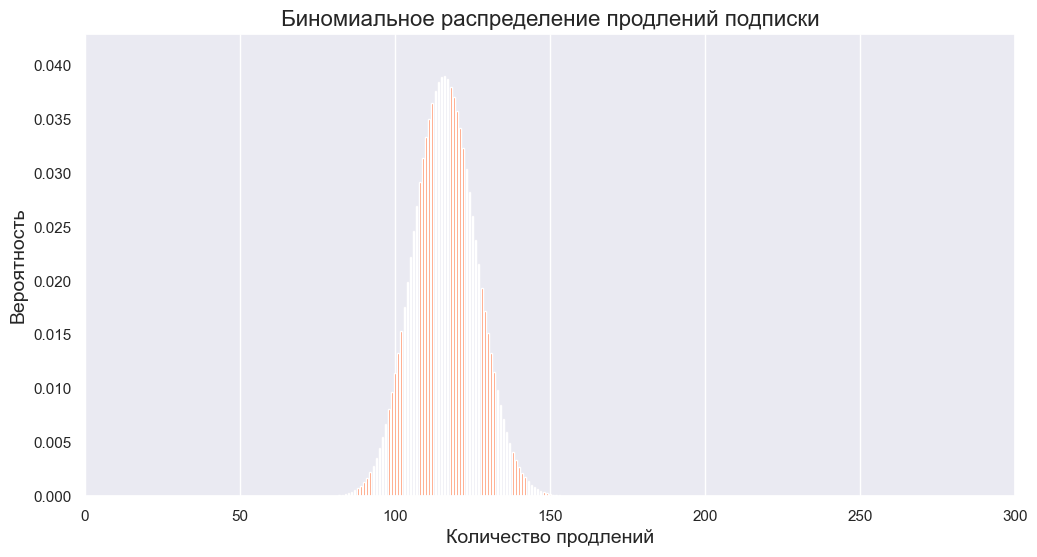

In [42]:
# так как в задаче звучит "подобрать", то будем перебирать число промокодов пока не найдем подходящее значение
# задаем параметры
p = 0.1  # вероятность продления
target = 100  # сколько юзеров должно продлить
alpha = 0.05  # уровень значимости для 95% вероятности

n = target  # начнем подбор с целевого значения в 100 промокодов
probability = 0

# ищем минимальное число промокодов что надо раздать
while probability < 1 - alpha:
    probability = 1 - binom.cdf(target - 1, n, p)
    n += 1

# n - это минимальное количество промокодов
print(f"Минимальное количество промокодов: {n - 1}")

# график распределения
x = np.arange(0, n)
y = binom.pmf(x, n - 1, p)

# создание графика
plt.figure(figsize=(12, 6))
plt.bar(x[x <= 300], y[x <= 300], color='coral', width=0.5)  # Ограничение по количеству продлений
plt.title('Биномиальное распределение продлений подписки', fontsize=16)
plt.xlabel('Количество продлений', fontsize=14)
plt.ylabel('Вероятность', fontsize=14)
plt.xlim(0, 300)  # Установите лимит по оси X
plt.ylim(0, max(y[x <= 300]) * 1.1)  # Установите лимит по оси Y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Таким образом, чтобы получить желаемый результат необходимо будет разослать минимум 1161 промокод  

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность того, что уведомление откроют не более 399500 пользователей: 15.3717%


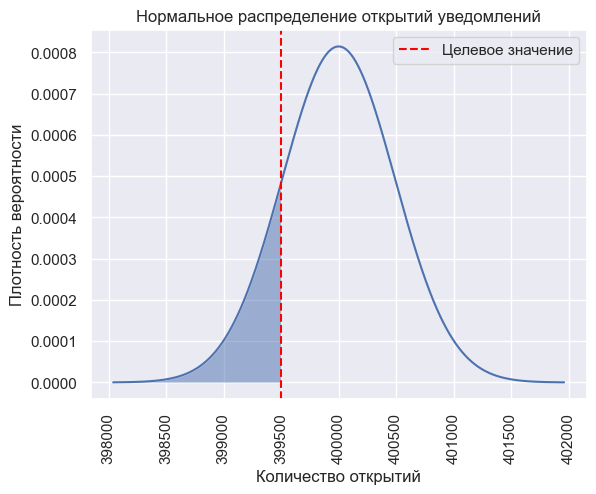

In [43]:
# параметры
p = 0.4  # вероятность открытия
n = 1000000  # число уведомлений
target = 399500  # целевое число открытий
alpha = 0.05

# расчет среднего и стандартного отклонения
mu = n * p  # среднее
sigma = np.sqrt(n * p * (1 - p))  # стандартное отклонение

# расчет z-значения
z = (target - mu) / sigma

# расчет вероятности
probability = norm.cdf(z)

# вывод результата
print(f"Вероятность того, что уведомление откроют не более {target} пользователей: {probability*100:.4f}%")

# построение графика
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y)
plt.fill_between(x, y, where=(x <= target), alpha=0.5)
plt.title('Нормальное распределение открытий уведомлений')
plt.xlabel('Количество открытий')
plt.ylabel('Плотность вероятности')
plt.axvline(target, color='red', linestyle='--', label='Целевое значение')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.show()


## Выводы по работе

В ходе работы были изучены данные сервиса аренды самокатов GoFast.  
На исследование были предоставлены данные о пользователях, их возрасте, откуда они, как использую сервис и сколько приносят прибыли для компании.  

В ходе работы мы обработали и объединили исходные таблицы со всеми указанными выше данными.  
Ключевые запросы в работе:
1) Выручка - в ходе исследования было установлено, что пользователи с подпиской приносят больше прибыли  
2) Плотность использования - пользователи с подпиской используются самокаты дольше по времени но на меньшие расстояния  
3) Износ - пользователи с подпиской не превышают приемлимые дистанции, после которых самокаты начинают сильнее изнашиваться  

Таким образом, пользователи с подпиской по всем параметрам выгоднее для сервиса и надо повышать их число.